# General dewscryption of the paper

The article presents unified framework of acne sewerity grading, which considers the relationship between global acne assessment and lesion simultaneously for acne image analysis.

They assert that most methods in acne lesion analysis inderictly focus on the classification or detection task  and generally rely on hand-crafted features. Also, standard single learning methods (SLL) ignore the ambiguity issue due to similar apperiance of acne images with close sewerity.

Their contribution consists of three main parts:
1. They provide multi-task model based on RES-NET for classification and regression (counting) task;
2. They generate two acne label distribution based on the professional grading criterion (Hayashi criterion);
3. They collect a new dataset *(ACNE04)*, which provides the annotations of acne severity and the bounding boxes of lesions annotated by professional dermatologists;

The main assumption to use multi-task model is that images with same class labels have similar features, that are important for regression-based methods.
They compare theur method with different Classification Methods and Counting methods. 

Their approach outperforms label distribution learning methods, hand-crafted feature based classification methods and deep methods in such metrics as precision, specifity, accuracy, sensitivity and Youden Index. What about counting task, their method shows better result compared to object detection methods (Faster R-CNN, YOLOv3, RefineDet) and regression method (MCNN) in such metrics as MAE and MSE.

Also they compare their result with 2 professional dermatologists and 2 general doctors in grading task. Their method achieves the dermatologist level performance and even exceeds the two dermatologists to a certain degree.

In conclusion, their results fully support the claims authors made about their approach.

# EDA

## First step is loading the data

In [1]:
import pandas as pd
import os
import numpy as np
import cv2 as cv
from glob import glob
from dask import bag, diagnostics
import xml.etree.ElementTree as ET

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp

sns.set_theme()
rcParams['figure.figsize'] = 20, 12

In [2]:
annotation_files = glob('../Detection/VOC2007/Annotations/*.xml')
image_files = glob('../Classification/JPEGImages/*.jpg')
train_val_fold_files = sorted(glob('../Classification/NNEW_trainval*.txt'))
test_fold_files = sorted(glob('../Classification/NNEW_test*.txt'))

In [65]:
base_path_to_img = '../Classification/JPEGImages/'

In [3]:
len(image_files)

1457

In [64]:
def bluriness_of_image(image):
    """
    Calculate blur extent of an image.
    If variance of 2nd derivative is too high, it means that the image has
    wide spread of responses (edges, center of objects and etc.) 
    Bluriness also can means contrast of an image
    """
    img = cv.imread(image)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return cv.Laplacian(gray, cv.CV_64F).var()

In [63]:
def bbox_area_covered(bboxes):
    """
    Calculate area covered by bboxes
    """
    union_area = 0
    for i in range(len(bboxes)):
        union_area += bboxes[i]['width'] * bboxes[i]['height']
        for j in range(i+1, len(bboxes)):
            x_min = max(bboxes[i]['xmin'], bboxes[j]['xmin'])
            y_min = max(bboxes[i]['ymin'], bboxes[j]['ymin'])
            x_max = min(bboxes[i]['xmax'], bboxes[j]['xmax'])
            y_max = min(bboxes[i]['ymax'], bboxes[j]['ymax'])
            if x_max < x_min or y_max < y_min:
                continue
            else:
                union_area -= (x_max - x_min) * (y_max - y_min)
    
    return union_area

In [66]:
def get_boxes(file):
    """
    Read annotations from xml
    :param file: path to xml annotation of an image
    :return: dictioanry and list of dictionaries 
    (first contains of img path and dimension data, 
    second contains of bbox data for that image).
    """

    def process_bndbox(bndbox):
        bbox = {}
        for el in bndbox:
            bbox[el.tag] = int(el.text)
            
        bbox['width'] = bbox['xmax'] - bbox['xmin']
        bbox['height'] = bbox['ymax'] - bbox['ymin']
        return bbox
    
    def add_bbox_el(obj_el, bbox_dict):
        converts = {
            "name": lambda x: {"name": x.text},
            "pose": lambda x: {"pose": x.text},
            "truncated": lambda x: {"truncated": int(x.text)},
            "difficult": lambda x: {"difficult": int(x.text)},
            "bndbox": lambda x: process_bndbox(x)
        }
        result = converts[obj_el.tag](obj_el)
        for key in result:
            bbox_dict[key] = result[key]

    data = {}

    tree = ET.parse(file)
    root = tree.getroot()
    data['filename'] = root.find('filename').text
    
    for el in root.find('size'):
        data[el.tag] = int(el.text)

    boxes = []
    for obj in root.findall('object'):

        box = {'filename':  data['filename']}
        for el in obj:
            add_bbox_el(el, box)
        boxes.append(box)

    area = bbox_area_covered(boxes)

    data['area'] = area
    data['damaged_area'] = area/(data['width'] * data['height'])
    data['bluriness'] = bluriness_of_image(base_path_to_img + data['filename'])
    return data, boxes

In [6]:
def get_severity(files):
    """
    Read files about acne severity level and num of lesions
    """
    data = []
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                row = {}
                splited = line.split()
                row['filename'] = splited[0]
                row['severity'] = int(splited[1])
                row['count'] = int(splited[2])
                data.append(row)
    return data

In [67]:
# parallel reading of annotation files

img_bag= bag.from_sequence(annotation_files).map(get_boxes)
with diagnostics.ProgressBar():
    img_data = img_bag.compute()

[########################################] | 100% Completed |  1min 24.5s


In [68]:
# splitting data to info associated to image and info associated to bbox'es

img_info, img_annotations = zip(*img_data)
img_annotations = [item for sublist in img_annotations for item in sublist]
img_severity = get_severity([test_fold_files[0], train_val_fold_files[0]])

In [69]:
img_info_df = pd.DataFrame(img_info).set_index(['filename'])
img_severity_df = pd.DataFrame(img_severity).set_index(['filename'])
acne_img_df = pd.merge(img_info_df, img_severity_df, left_index=True, right_index=True)

In [10]:
img_annotations_df = pd.DataFrame(img_annotations)

## Relation between size of the images and acne severity level

In [11]:
acne_img_df

,width,height,depth,area,damaged_area,severity,count
filename,,,,,,,
levle0_158.jpg,3112,3456,3,50355,0.004682,0,2
levle1_439.jpg,3112,3456,3,94875,0.008821,1,6
levle3_36.jpg,2592,1944,3,435852,0.086498,3,52
levle0_164.jpg,3112,3456,3,84466,0.007854,0,3
levle1_377.jpg,3112,3456,3,185492,0.017247,1,8
...,...,...,...,...,...,...,...
levle1_420.jpg,3112,3456,3,111964,0.010410,1,6
levle1_434.jpg,3112,3456,3,247706,0.023032,1,12
levle3_13.jpg,690,920,3,67089,0.105685,3,54


In [12]:
acne_img_df.describe()

,width,height,depth,area,damaged_area,severity,count
count,1457.000000,1457.000000,1457.0,1.457000e+03,1457.000000,1457.000000,1457.000000
mean,2918.286205,3027.748799,3.0,1.568003e+05,0.027083,0.949897,13.028826
std,1112.872289,1002.736785,0.0,2.118102e+05,0.041112,0.910614,16.111280
min,143.000000,155.000000,3.0,1.710000e+02,0.000545,0.000000,1.000000
25%,3112.000000,3456.000000,3.0,3.938600e+04,0.005368,0.000000,3.000000
50%,3112.000000,3456.000000,3.0,9.667000e+04,0.012366,1.000000,7.000000
75%,3112.000000,3456.000000,3.0,1.819480e+05,0.025138,1.000000,13.000000
max,5184.000000,3456.000000,3.0,2.509228e+06,0.290902,3.000000,65.000000


In [13]:
def plot_scatter_hw(sizes):
    plt.xlabel('width')
    plt.ylabel('height')
    s = [20*n for n in sizes['count']]
    plt.scatter(x=sizes['width'], y=sizes['height'], c=sizes['severity'], s=s, alpha=0.6, cmap="viridis")
    cbar = plt.colorbar()
    plt.show()

In [14]:
sizes = acne_img_df.groupby(['height', 'width', 'severity']).size().reset_index().rename(columns={0:'count'})

In [15]:
len(sizes.width.unique()), len(sizes.height.unique()), len(sizes)

(112, 138, 178)

/var/folders/qf/7hdx9_t143q6b92tgz5nyt7r0000gn/T/ipykernel_20059/2350934785.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


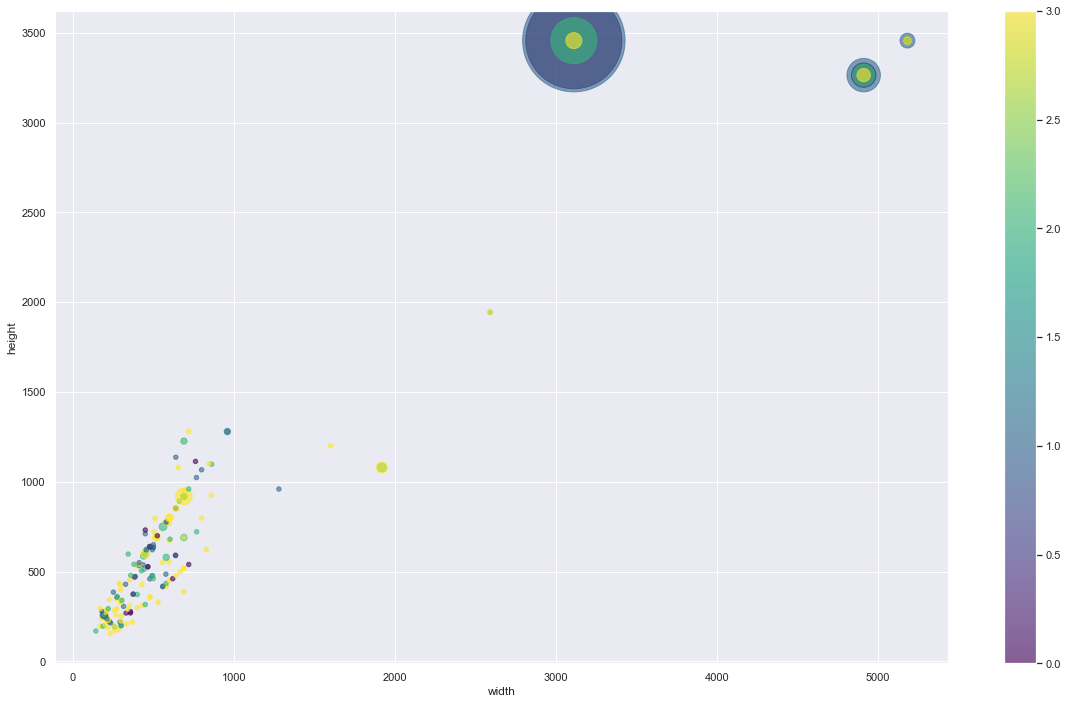

In [16]:
plot_scatter_hw(sizes)

In [17]:
most_freq_size = sizes.loc[sizes['count'].idxmax()] 
np.sum(sizes[sizes['width'] == most_freq_size['width']][sizes['height'] == most_freq_size['height']]['count']) / np.sum(sizes['count'])

/var/folders/qf/7hdx9_t143q6b92tgz5nyt7r0000gn/T/ipykernel_20059/314000213.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(sizes[sizes['width'] == most_freq_size['width']][sizes['height'] == most_freq_size['height']]['count']) / np.sum(sizes['count'])


0.759780370624571

We can see, that majority of images have certain size (3456x3112). And number of images with that resolution is 74.4%. The low, medium and high resoulution frequencies can also be obtained.

In [18]:
total = np.sum(sizes['count'])

low_res_freq = np.sum(sizes[sizes['width'] < 1000]['count']) / total
medium_res_freq = np.sum(sizes[sizes['width'] > 1000][sizes['width'] < 3000]['count']) / total
high_res_freq = np.sum(sizes[sizes['width'] > 2500]['count']) / total

print("Low resolution frequency: ", low_res_freq)
print("Medium resolution frequency: ", medium_res_freq)
print("High resolution frequency: ", high_res_freq)

Low resolution frequency:  0.13589567604667124
Medium resolution frequency:  0.009608785175017159
High resolution frequency:  0.8558682223747426


/var/folders/qf/7hdx9_t143q6b92tgz5nyt7r0000gn/T/ipykernel_20059/3079890741.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  medium_res_freq = np.sum(sizes[sizes['width'] > 1000][sizes['width'] < 3000]['count']) / total


/var/folders/qf/7hdx9_t143q6b92tgz5nyt7r0000gn/T/ipykernel_20059/2350934785.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


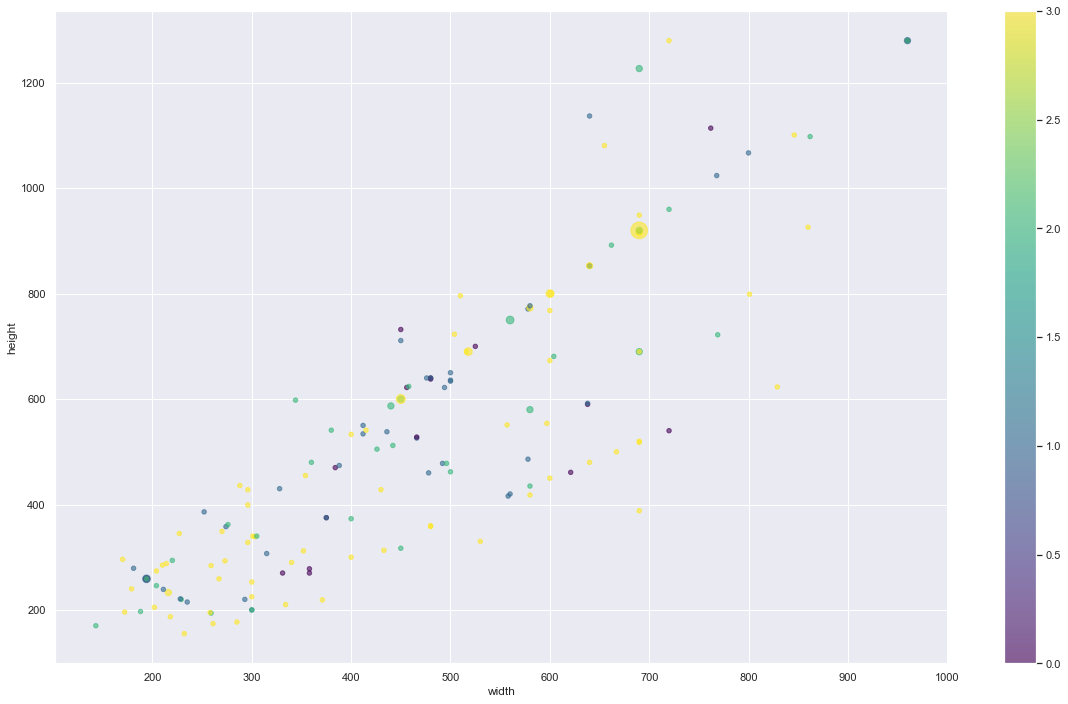

In [19]:
#plot only low resolution images

plot_scatter_hw(sizes[sizes['width'] < 1000])

## Let's check total distribution of num of lesions and severity levels

array([[<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'severity'}>]], dtype=object)

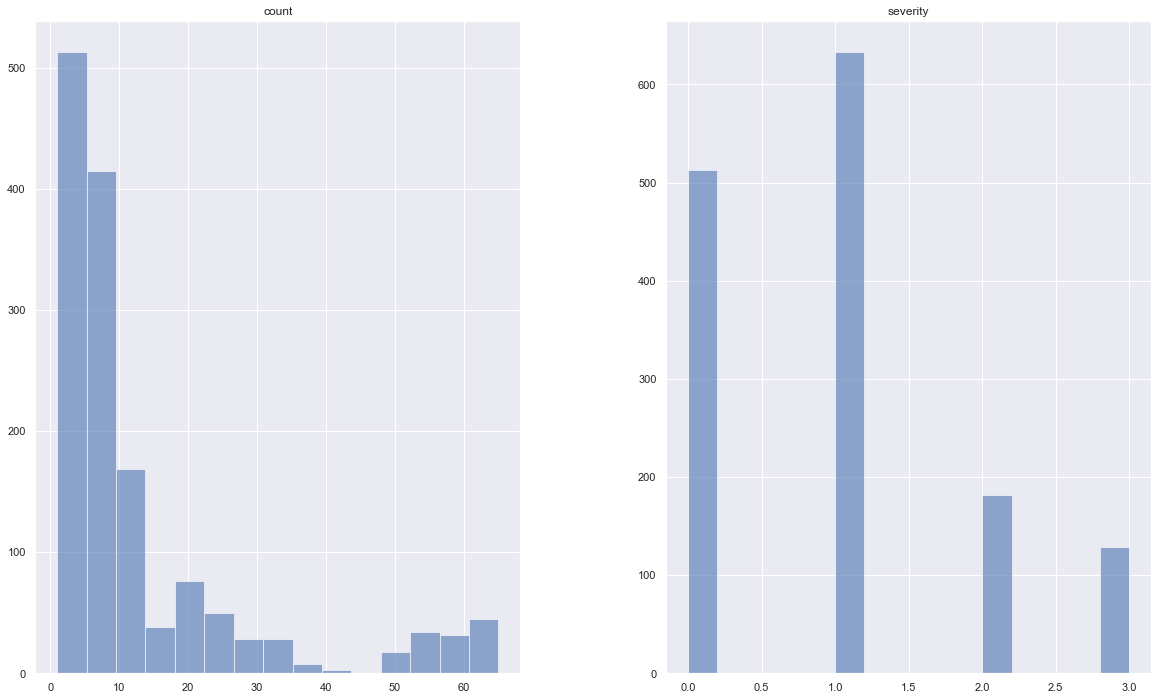

In [20]:
acne_img_df[['count', 'severity']].hist(bins=15, alpha=0.6)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

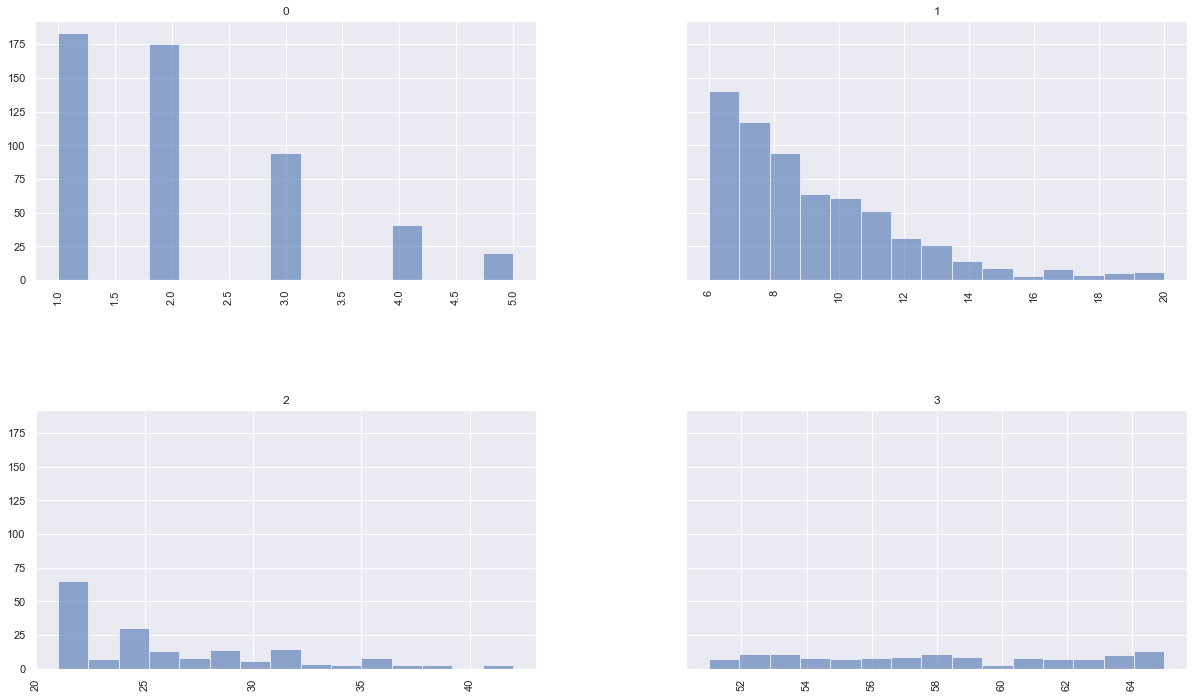

In [21]:
#plot histogramm of num of lession according to severity level

acne_img_df.hist(column='count', by='severity', bins=15, alpha=0.6,  sharey=True)

<AxesSubplot:xlabel='severity', ylabel='count'>

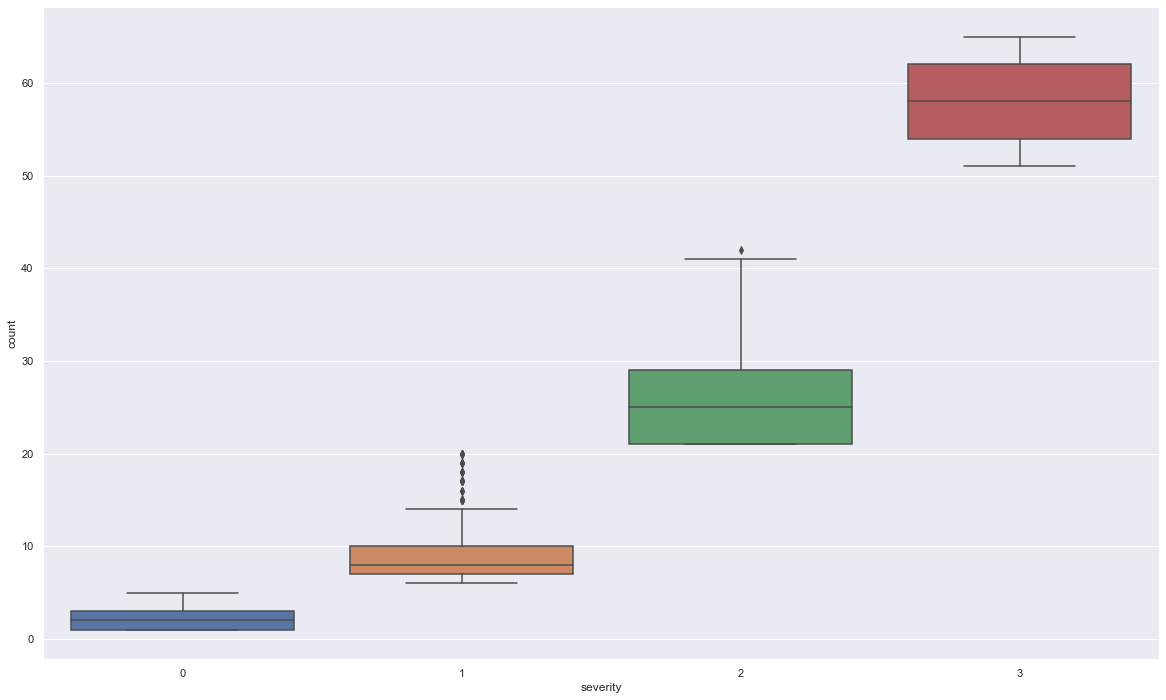

In [22]:
sns.boxplot(y='count', x='severity', data=acne_img_df)

Distributions of number of lessions according to acne severity level are shifted to right edge. (It can be seen on histogtam and box plot) 

It means, that experts prefer to choose more serious severity level if the number of lesions are close to the right border of it's severity level. 

Also, it explains, very severe levele has uniform distribution.

## Check thats distributions on low and high resolution images

### Plot distribution of low resolution images

In [23]:
low_res_acne_df = acne_img_df[acne_img_df['width'] < 2000]

array([[<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'severity'}>]], dtype=object)

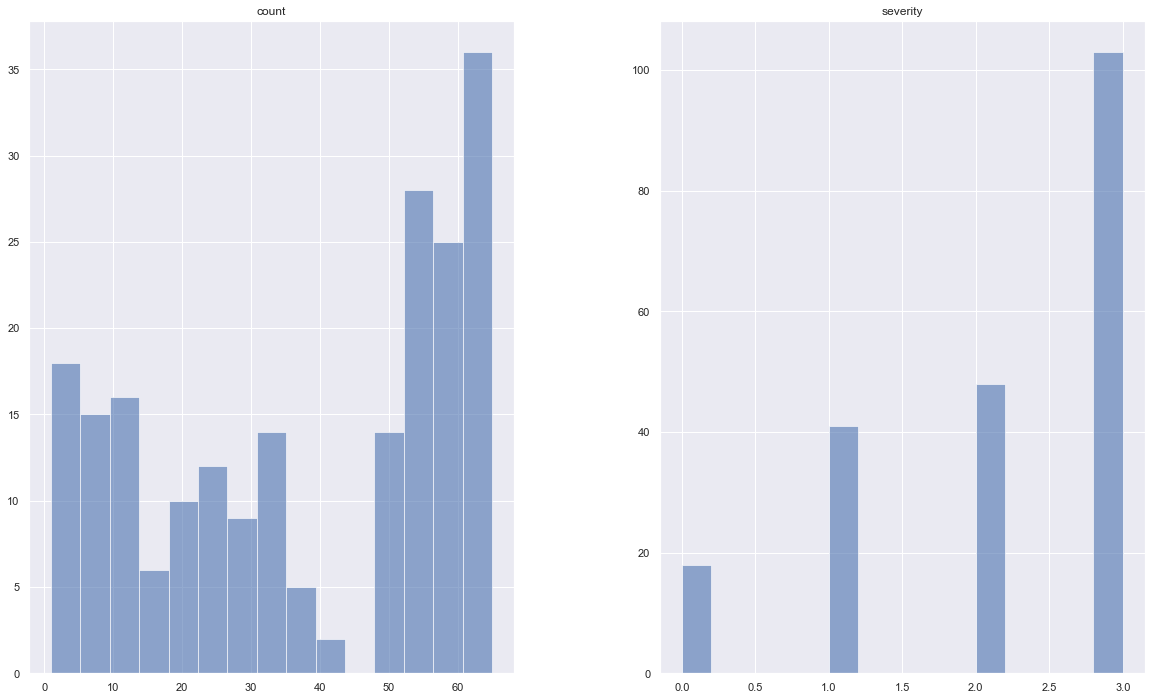

In [24]:
low_res_acne_df[['count', 'severity']].hist(bins=15, alpha=0.6)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

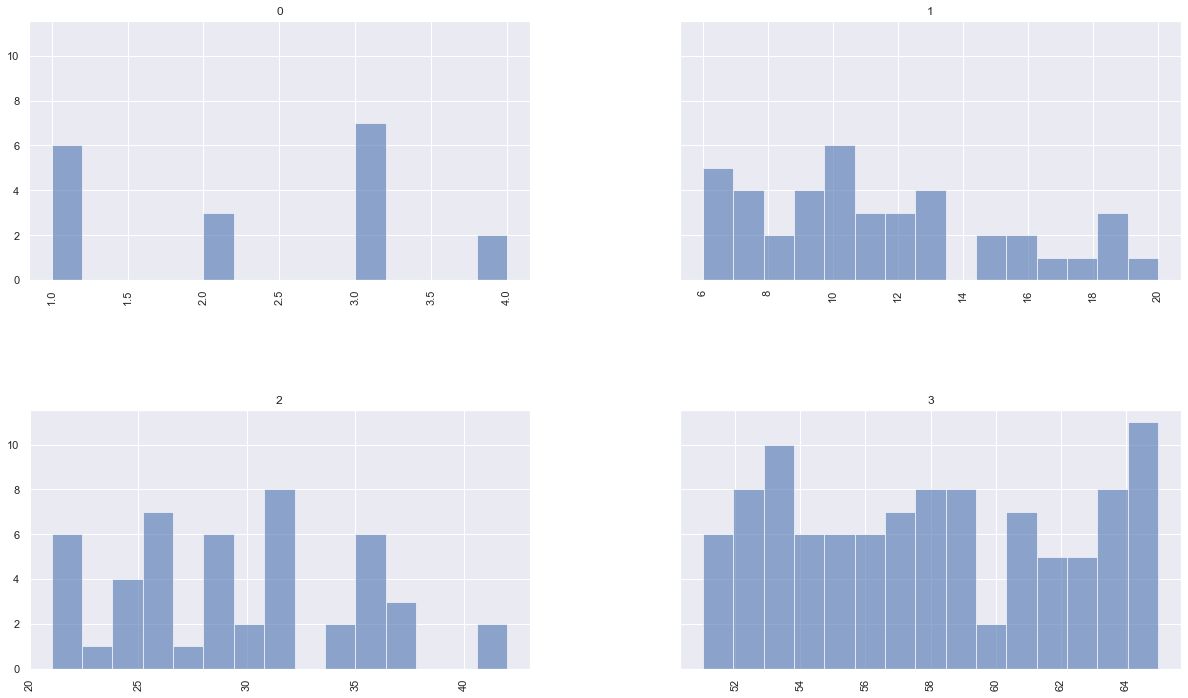

In [25]:
low_res_acne_df.hist(column='count', by='severity', bins=15, alpha=0.6, sharey=True)

### Plot distribution of high resolution images

In [26]:
high_res_acne_df = acne_img_df[acne_img_df['width'] > 2000]

array([[<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'severity'}>]], dtype=object)

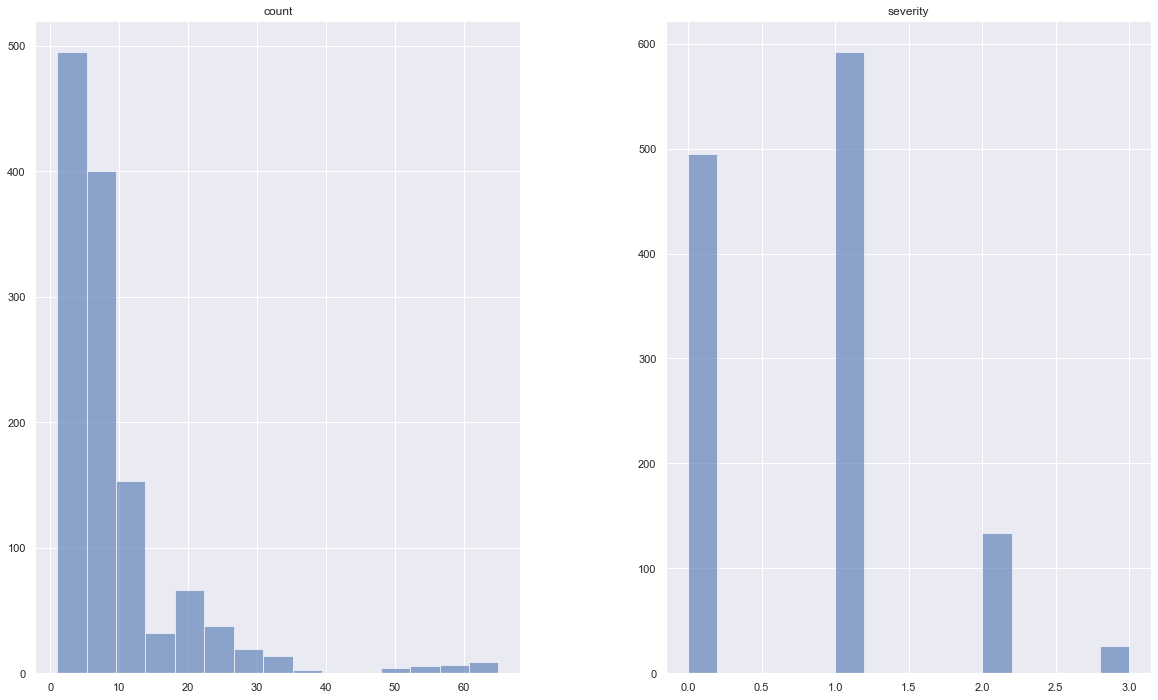

In [27]:
high_res_acne_df[['count', 'severity']].hist(bins=15, alpha=0.6)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

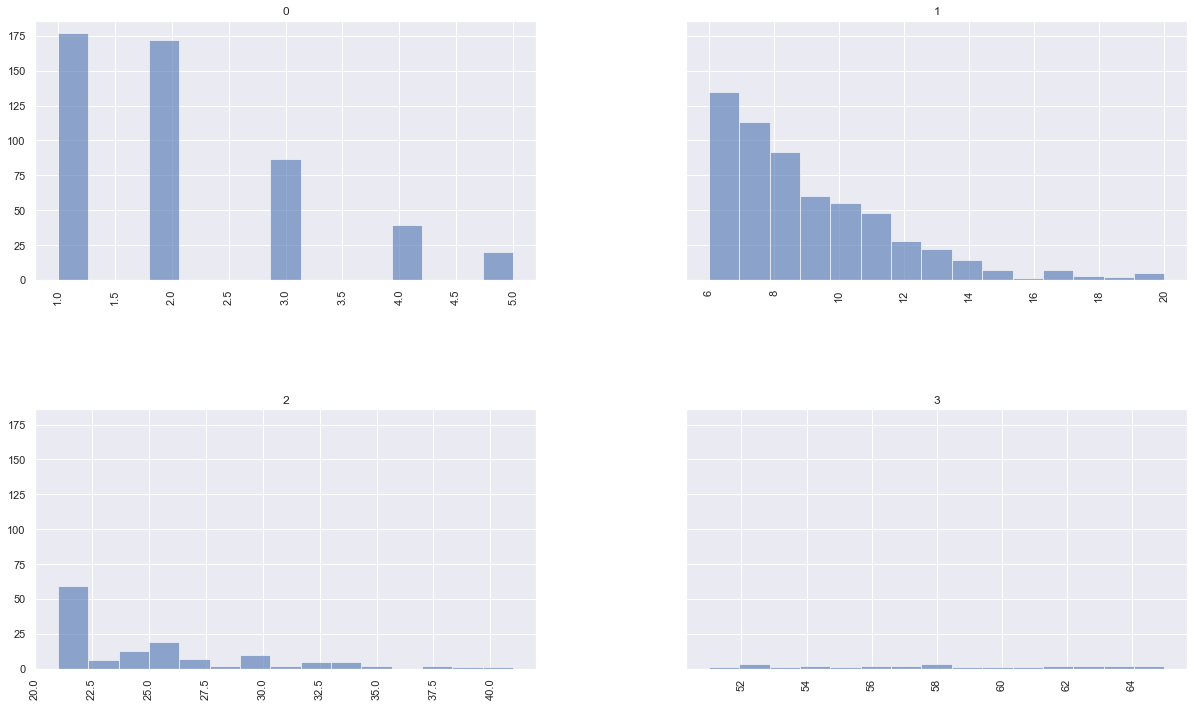

In [28]:
high_res_acne_df.hist(column='count', by='severity', bins=15, alpha=0.6, sharey=True)

The distributions of low resolution images are different from high resolution images. We can compare these distributions.

### Compare distributions

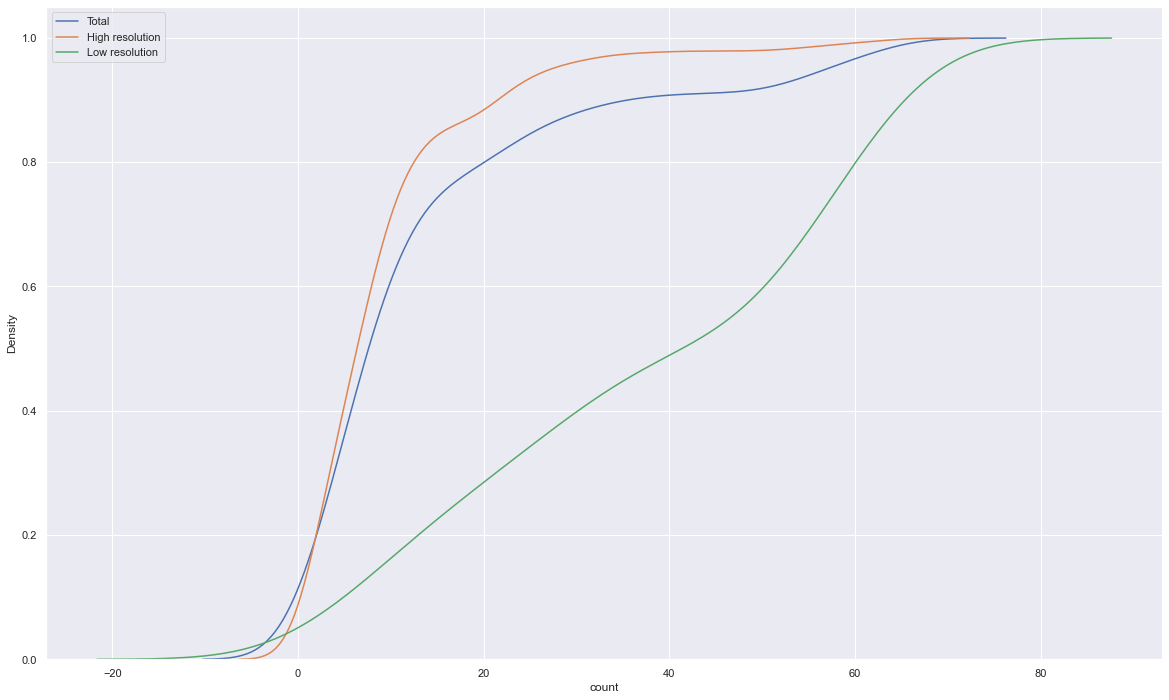

In [29]:
sns.kdeplot(data=acne_img_df, cumulative=True, x='count', label='Total')
sns.kdeplot(data=high_res_acne_df, cumulative=True, x='count', label='High resolution')
sns.kdeplot(data=low_res_acne_df, cumulative=True, x='count', label='Low resolution')
plt.legend()

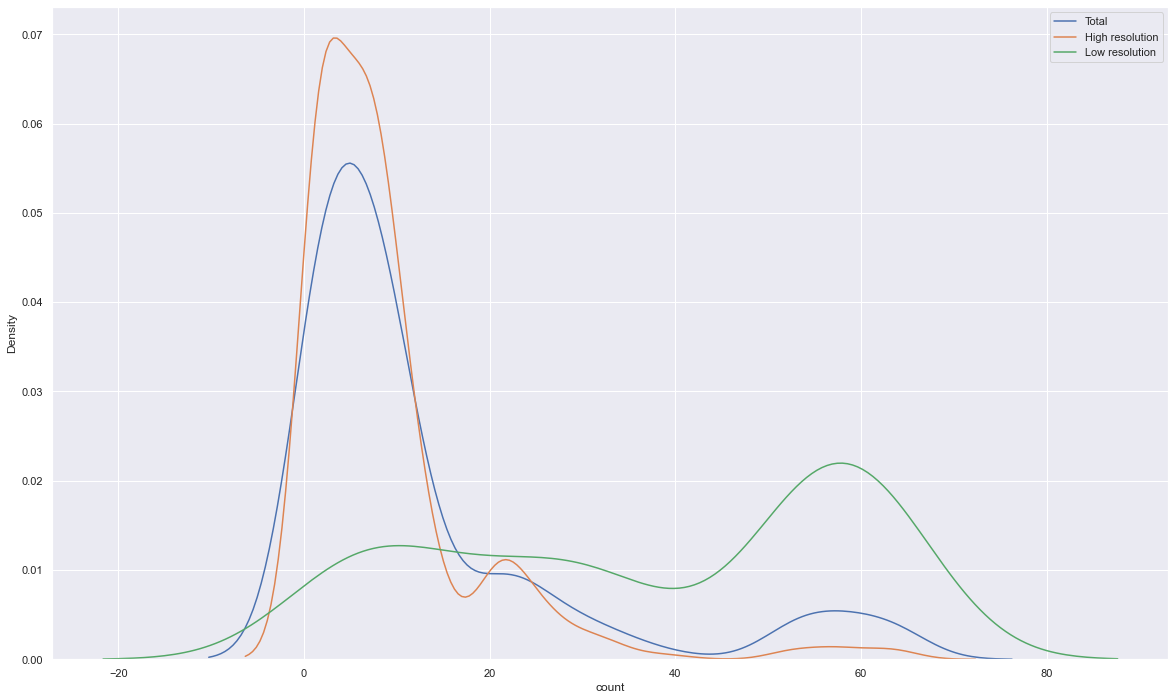

In [30]:
sns.kdeplot(data=acne_img_df, x='count', label='Total')
sns.kdeplot(data=high_res_acne_df, x='count', label='High resolution')
sns.kdeplot(data=low_res_acne_df, x='count', label='Low resolution')
plt.legend()

We can see, that num of lesions distribution for high and low resolutions is different. Let's perform Kolmogorov-Smirnov test to proof this.

Critical value for that test can be calculated using this equsion: $$D_a=c(a)\sqrt{\frac{n_1+n_2}{n_1n_2}}$$where $$n_1, n_2$$ size of samples.

In [31]:
def compare_two_distr(v1, v2, alpha):
    coef = {
        '0.01': 1.63,
        '0.005': 1.73,
        '0.001': 1.95,
    }

    s_v1 = len(v1)
    s_v2 = len(v2)

    critical_value = coef[alpha] * np.sqrt((s_v2 + s_v1)/(s_v1 * s_v2))
    kstest = ks_2samp(v1, v2)

    return kstest[0], critical_value

In [32]:
compare_two_distr(low_res_acne_df['count'], high_res_acne_df['count'], '0.001')

(0.6183106121357925, 0.14545260816230363)

We can see, that statistic value is much higher than critical value. It means, that these two distribution are different.
Very severe level most often found in low resolution images (width < 2000). And conversely, mild and moderate levels are more common in high resolution images. So doctors tend to annotate low resolution images wiht higher acne severity level. It can be xplained by the fact, that on these images it much harder to distinguish lesion areas, so they prefer to annotate how much as possible.

## Bbox analysis

In [34]:
img_annotations_df

,filename,name,pose,truncated,difficult,xmin,ymin,xmax,ymax,width,height
0,levle0_158.jpg,fore,Unspecified,0.0,0,1114,2435,1306,2589,192,154
1,levle0_158.jpg,fore,Unspecified,0.0,0,692,2274,861,2397,169,123
2,levle1_439.jpg,fore,Unspecified,0.0,0,922,2175,999,2290,77,115
3,levle1_439.jpg,fore,Unspecified,0.0,0,1198,2221,1344,2313,146,92
4,levle1_439.jpg,fore,Unspecified,0.0,0,662,1983,800,2106,138,123
...,...,...,...,...,...,...,...,...,...,...,...
18978,levle1_352.jpg,fore,Unspecified,0.0,0,2493,2320,2708,2535,215,215
18979,levle1_352.jpg,fore,Unspecified,0.0,0,1850,2389,1980,2543,130,154
18980,levle1_352.jpg,fore,Unspecified,0.0,0,1949,2290,2110,2420,161,130
18981,levle1_352.jpg,fore,Unspecified,0.0,0,1290,995,1443,1179,153,184


In [35]:
img_annotations_df.describe()

,truncated,difficult,xmin,ymin,xmax,ymax,width,height
count,11221.0,18983.0,18983.000000,18983.000000,18983.000000,18983.000000,18983.000000,18983.00000
mean,0.0,0.0,1095.126113,1315.148870,1188.309751,1408.259390,93.183638,93.11052
std,0.0,0.0,914.536200,1037.610401,959.200774,1082.770977,64.905289,64.22493
min,0.0,0.0,0.000000,0.000000,7.000000,7.000000,4.000000,4.00000
25%,0.0,0.0,262.000000,309.500000,297.000000,346.000000,30.000000,30.00000
50%,0.0,0.0,867.000000,1047.000000,991.000000,1186.000000,93.000000,99.00000
75%,0.0,0.0,1827.000000,2297.000000,1965.000000,2435.000000,141.000000,145.00000
max,0.0,0.0,4520.000000,3363.000000,4753.000000,3455.000000,514.000000,491.00000


In [36]:
rand_img_file = image_files[21].split("/")[-1]

In [98]:
def draw_img(imgs, annotations):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_axis_off()
    for i, img_f in enumerate(imgs.iterrows()):
        a = fig.add_subplot(1, 3, i + 1)
        img = cv.cvtColor(cv.imread(base_path_to_img + img_f[0]), cv.COLOR_BGR2RGB)

        h0, w0 = img.shape[:2]
        scale_w, scale_h = 1024/w0, 1024/h0
        h, w = int(round(h0 * scale_h)), int(round(w0 * scale_w))
        img = cv.resize(img, (h, w), interpolation=cv.INTER_AREA)

        annotation = annotations[annotations['filename'] == img_f[0]]
        for row in annotation.iterrows():
            r = row[1]
            img = cv.rectangle(img, (int(r.xmin * scale_w), int(r.ymin * scale_h)),\
                    (int(r.xmax * scale_w), int(r.ymax * scale_h)), (0,255,0), 4)
        plt.title(f"Severity: {img_f[1]['severity']}\n Lesions: {img_f[1]['count']}\n Size {int(img_f[1]['width'])}x{int(img_f[1]['height'])}", fontsize=10)
        plt.axis('off')
        plt.imshow(img)

In [83]:
def get_random_imgs(imgs, n, severity=0):
    return imgs[imgs['severity'] == severity].sample(n=n, random_state=2)

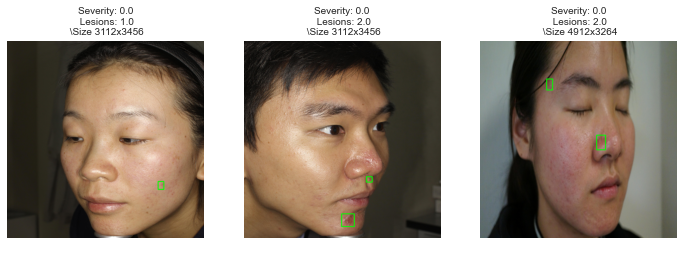

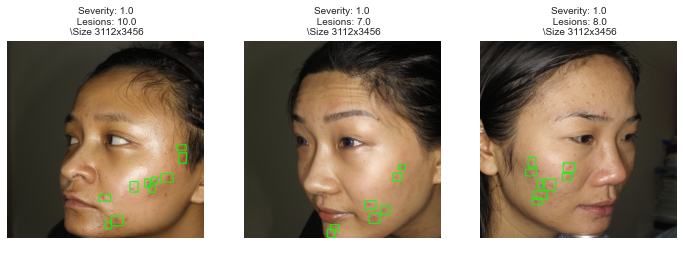

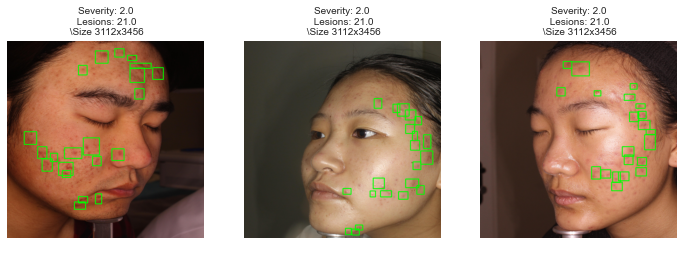

In [99]:
draw_img(get_random_imgs(acne_img_df, 3, 0), img_annotations_df)
draw_img(get_random_imgs(acne_img_df, 3, 1), img_annotations_df)
draw_img(get_random_imgs(acne_img_df, 3, 2), img_annotations_df)

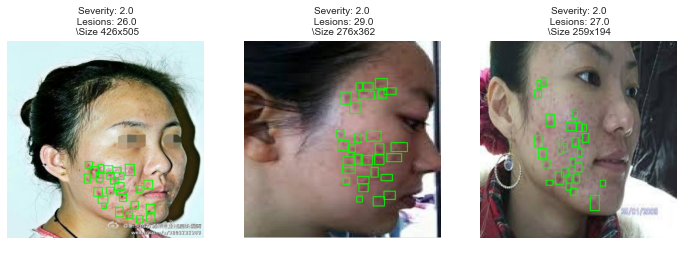

In [102]:
draw_img(get_random_imgs(acne_img_df[acne_img_df['bluriness'] > 500], 3, 2), img_annotations_df)

<AxesSubplot:>

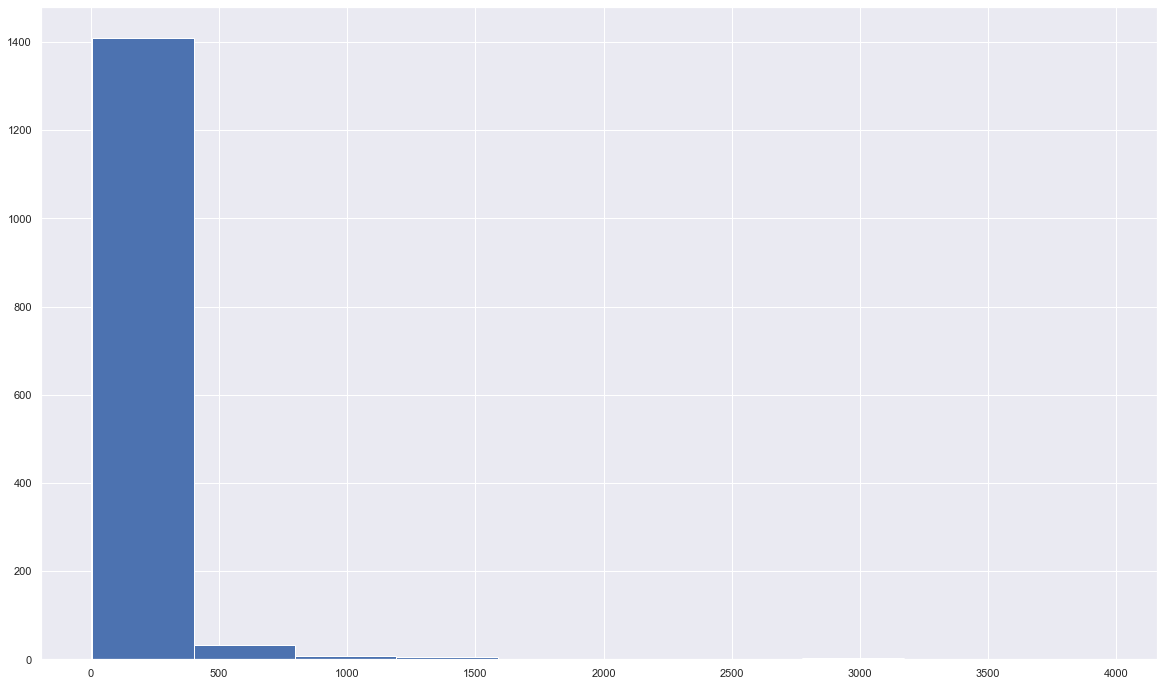

In [70]:
acne_img_df['bluriness'].hist()

<AxesSubplot:>

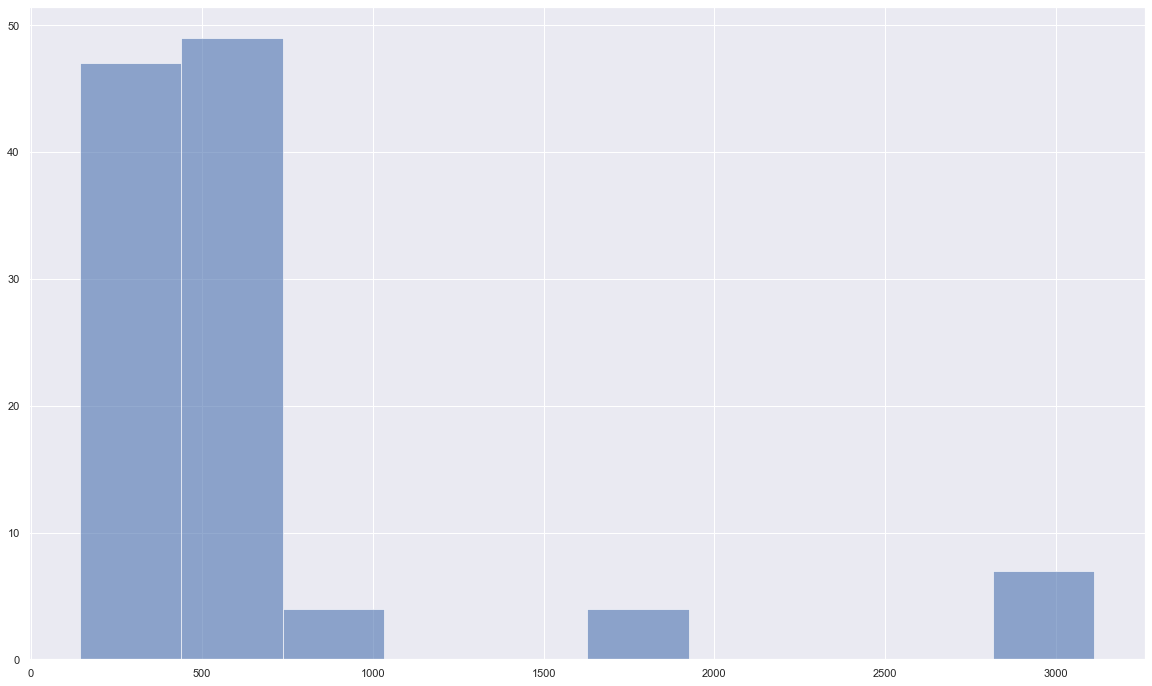

In [116]:
acne_img_df[acne_img_df['bluriness'] > 200]['width'].hist(alpha=0.6)

We can see, that majority of images have low contrast. The high contrast images have low resolution respectively. And as we know, low resolution images tend to be annotated with high acne severy level. So, let's check the dependence of severe level from contrast.

In [118]:
blur_df = acne_img_df.groupby(['bluriness', 'count', 'severity']).size().reset_index().rename(columns={0:'size'})

/var/folders/qf/7hdx9_t143q6b92tgz5nyt7r0000gn/T/ipykernel_20059/1613934561.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="severity level")


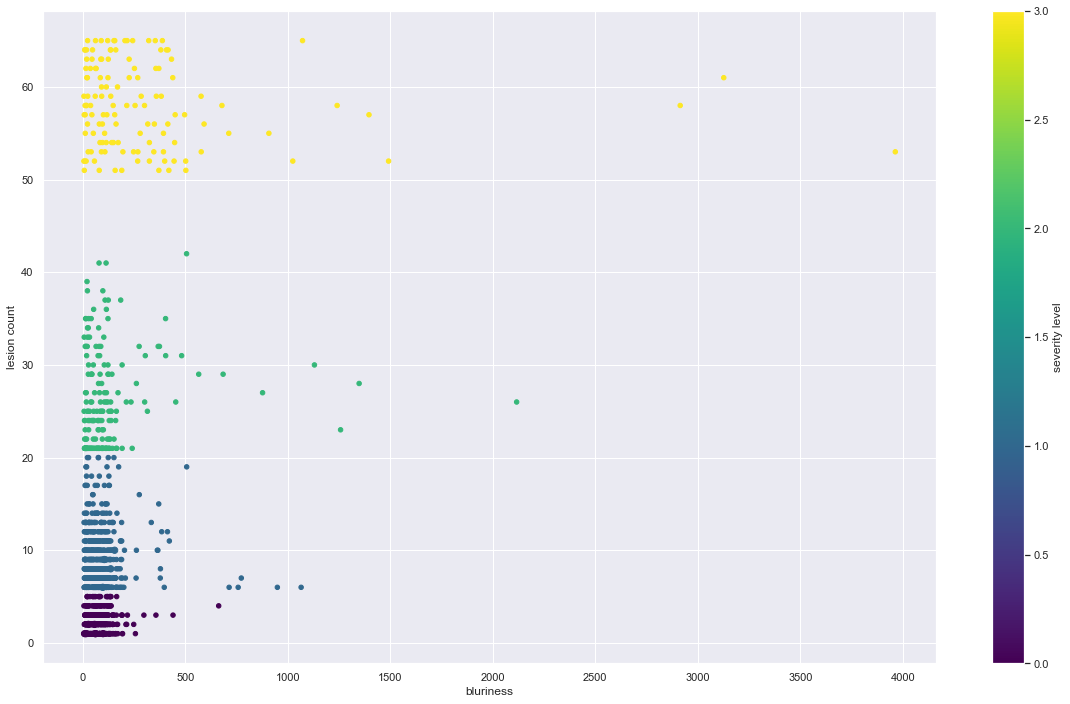

In [123]:
plt.xlabel('bluriness')
plt.ylabel('lesion count')
s = [20*n for n in blur_df['size']]
plt.scatter(x=blur_df['bluriness'], y=blur_df['count'], s=s, c=blur_df['severity'], cmap='viridis')
plt.colorbar(label="severity level")

The diagram above confirms, that low severity images have low contrast. And deviation of blurines of images becomes higher according to severity level.

### Dependencies between size of bounding boxes and severity levels

Damaged area is the precentage of image contains lesions. Let's show some dependencies of this area from other values.

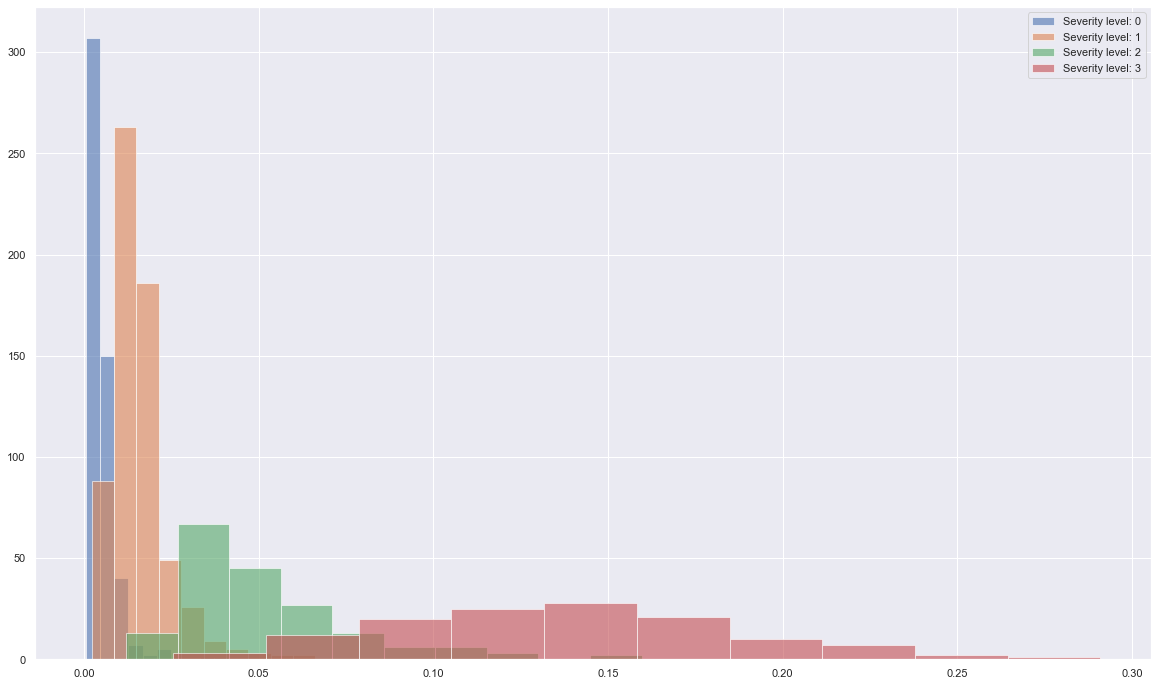

In [136]:
for i in range(4):
    acne_img_df[acne_img_df['severity'] == i]['damaged_area'].hist(alpha=0.6, label=f"Severity level: {i}")
plt.legend()

<AxesSubplot:xlabel='severity', ylabel='damaged_area'>

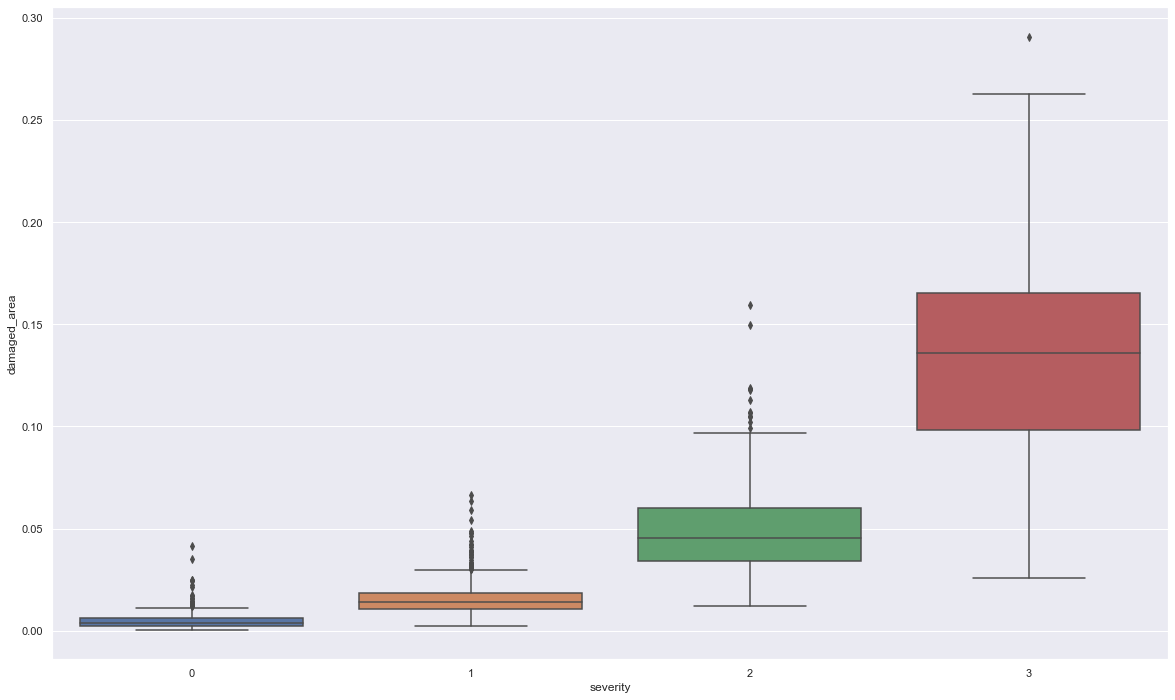

In [133]:
sns.boxplot(y='damaged_area', x='severity', data=acne_img_df)

/var/folders/qf/7hdx9_t143q6b92tgz5nyt7r0000gn/T/ipykernel_20059/1239237246.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="severity level")


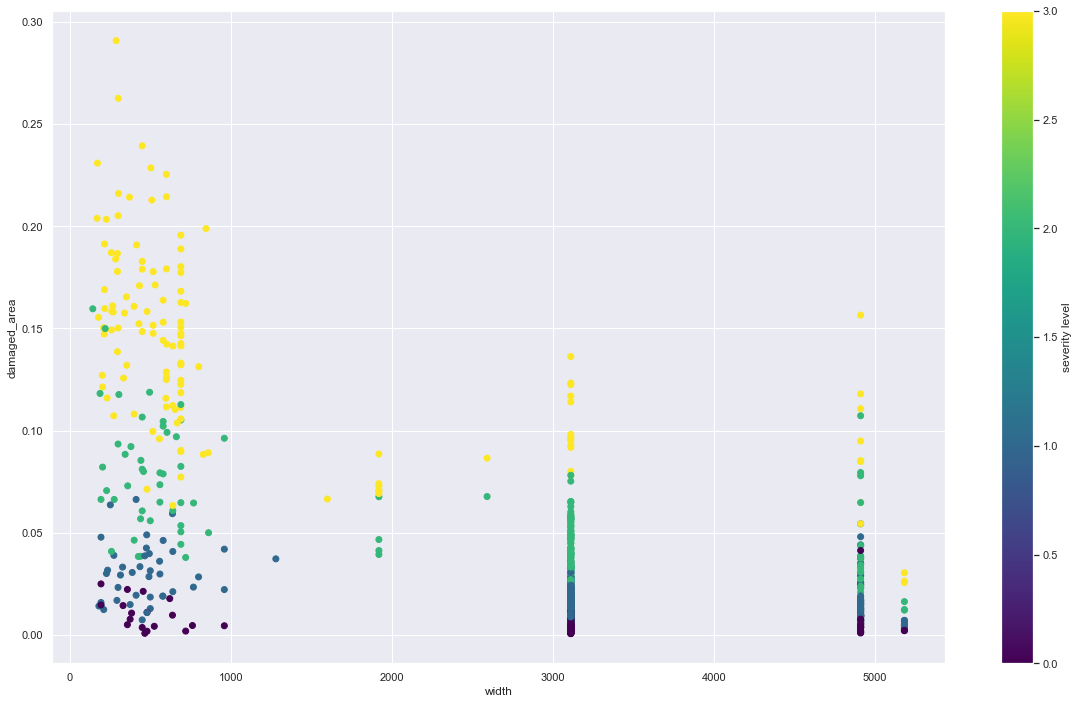

In [141]:
plt.xlabel('width')
plt.ylabel('damaged_area')
plt.scatter(x=acne_img_df['width'], y=acne_img_df['damaged_area'], c=acne_img_df['severity'], cmap='viridis')
plt.colorbar(label="severity level")

<AxesSubplot:>

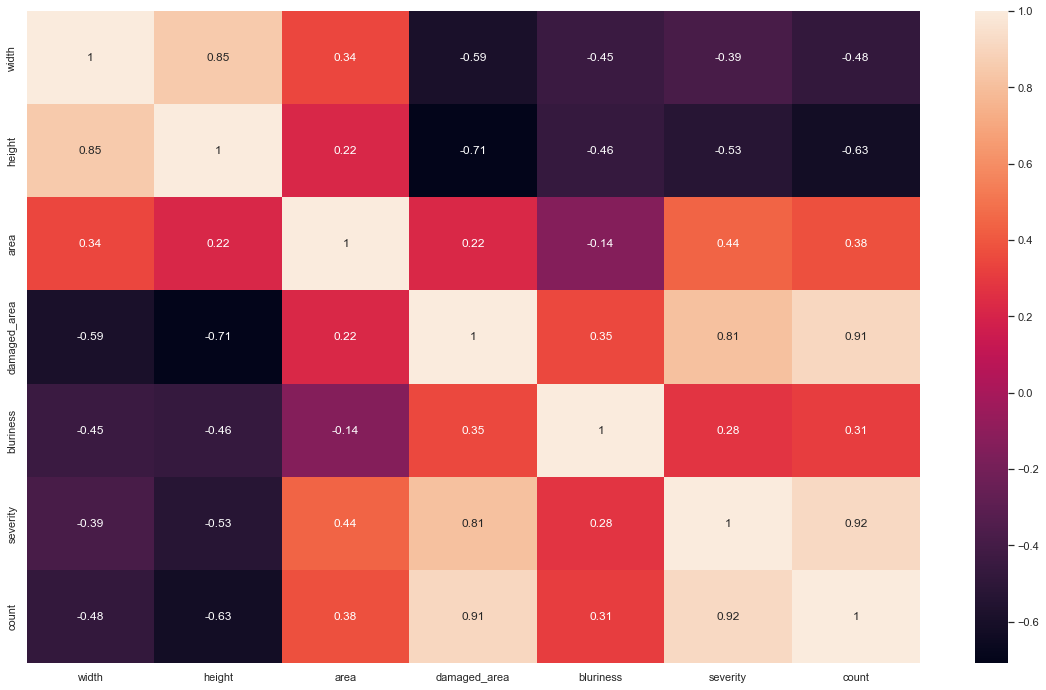

In [148]:
sns.heatmap(acne_img_df.drop(columns=["depth"]).corr(), annot=True)

Heatmap above confirms all statement abount dependencies in our data. Also, we can see negarive correlation between damaged_area and size of an image. It can be explained by the fact that doctors can annotate smaller regions inside high resolution image.